# Exproratory Data Analysis
In this analysis, we deconstruct the price action of Bitcoin to understand its underlying market dynamics. Beyond simple price visualization, we investigate the statistical structure of returns across different timeframes. Our goal is to isolate the signal from the noise, identifying volatility clusters and seasonal patterns that drive market risk, laying the groundwork for predictive modeling.

# 📑 Table of Contents: Bitcoin Market Analysis (EDA)

This notebook presents a comprehensive statistical analysis of the BTC/USDT time series, focusing on its stochastic properties to determine the appropriate modeling approach.

---

### 1. [Introduction & Research Objectives](#1)
   - Analysis context and scope.
   - Hypothesis definition: Stationarity, Normality, and Market Efficiency.

### 2. [Data Preprocessing & Transformation](#2)
   - Data cleaning and `DatetimeIndex` handling.
   - Calculation of logaritmic returns.

### 3. [Distribution Analysis](#3)
   - Descriptive Statistics (Skewness, Kurtosis).
   - **Histogram & KDE:** Visualizing non-normality.
   - **Q-Q Plot:** Visual detection of Fat Tails.

### 4. [Outlier Detection & Analysis](#4)
   - Boxplots and Interquartile Range (IQR) analysis.
   - Identification of Extreme Value Events ("Black Swans").

### 5. [Stationarity Analysis](#5)
   - **Rolling Statistics:** Visualizing mean and variance stability.
   - **Augmented Dickey-Fuller (ADF) Test:** Formal unit root testing.

### 6. [Serial Correlation Structure](#6)
   - **ACF/PACF of Raw Returns:** Testing Weak-Form Market Efficiency.
   - **ACF of Squared Returns ($r^2$):** Detecting Volatility Clustering.
   - Volume vs. Volatility dynamics.

### 7. [Multi-Timeframe Seasonal Decomposition](#7)
   - **Long-Term Trend:** Monthly decomposition analysis.
   - **The "Weekend Effect":** Weekly seasonality analysis.
   - **Market Microstructure:** Intraday (5-min) session analysis.

### 8. [Heteroskedasticity Diagnosis](#8)
   - Visual inspection of Residuals ($R_t$).
   - **Engle’s ARCH LM Test:** Formal validation for GARCH modeling.

### 9. [Final Conclusions & Executive Summary](#9)
   - Synthesis of statistical findings.
   - Implications for predictive modeling (ARIMA vs. GARCH).

---

<a id="1"></a>
## 1. Introduction & Research Objectives

### 1.1. Context
Bitcoin (BTC) is characterized by extreme volatility and non-linear dynamics, posing significant challenges for traditional financial modeling. In this notebook, we perform a rigorous Exploratory Data Analysis (EDA) on the BTC/USDT pair.

Unlike standard data analysis, financial time series analysis requires a specific focus on stationarity, serial correlation, and conditional variance. Understanding these properties is a prerequisite for implementing advanced forecasting models such as ARIMA or GARCH.

### 1.2. Research Objectives
The primary goal of this study is to diagnose the statistical properties of Bitcoin returns across multiple timeframes (Daily, Hourly, 5-Minutes). Specifically, we aim to:

1.  **Assess Stationarity:** Determine if the log-returns follow a stationary process using the Augmented Dickey-Fuller (ADF) test.
2.  **Test for Normality:** Evaluate the distribution of returns to detect leptokurtosis (fat tails) and deviations from the Gaussian assumption.
3.  **Analyze Market Memory:** Investigate the serial correlation of prices (Efficient Market Hypothesis) versus the serial correlation of volatility.
4.  **Detect Heteroskedasticity:** Confirm the presence of ARCH effects (volatility clustering) to validate the necessity of non-linear variance models.

### 1.3. Key Hypotheses
Throughout this analysis, we will test the following statistical hypotheses:
* **$H_0$ (Normality):** Returns follow a Normal Distribution.
* **$H_0$ (Stationarity):** The series has a Unit Root.
* **$H_0$ (No ARCH Effects):** The variance of the error term is constant.

---

<a id="2"></a>
## 2. Data Preprocessing & Transformation

In this section, we load the historical dataset and perform the necessary preprocessing steps to ensure data quality. This involves:

1.  **Data Loading & Cleaning:** Importing raw data and handling missing values.
2.  **Index Standardization:** Converting the time column to a `DatetimeIndex`.
3.  **Feature Engineering (Log-Returns):**
    Instead of analyzing raw prices, which are non-stationary, we calculate the Logarithmic Returns. Log-returns are preferred in financial mathematics because they are time-additive and tend to stabilize the variance.

---

In [64]:
!pip install statsmodels
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats 
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Importing datasets
df_1h = pd.read_csv('../data/btcusdt_1h_2018_indicators.csv')
df_1d = pd.read_csv('../data/btcusdt_1d_2018_preprocessed.csv')
df_5m = pd.read_csv('../data/btcusdt_5m_2018_preprocessed.csv')

# Converting 'Date' columns to datetime and setting as index
df_1d['Date'] = pd.to_datetime(df_1d['Date'])
df_1d.set_index('Date', inplace=True)
df_1h['Date'] = pd.to_datetime(df_1h['Date'])
df_1h.set_index('Date', inplace=True)
df_5m['Date'] = pd.to_datetime(df_5m['Date'])
df_5m.set_index('Date', inplace=True)

# Logarithmic Returns Calculation
df_1d['log_return'] = np.log(df_1d['Close'] / df_1d['Close'].shift(1))
df_1d.dropna(inplace=True)
df_1h['log_return'] = np.log(df_1h['Close'] / df_1h['Close'].shift(1))
df_1h.dropna(inplace=True)
df_5m['log_return'] = np.log(df_5m['Close'] / df_5m['Close'].shift(1))
df_5m.dropna(inplace=True)

# Displaying the first few rows dayly dataframe
df_1d.head()


,Open,High,Low,Close,Volume,log_return
Date,,,,,,
2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,0.092392
2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639,0.016517
2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.649574,0.009342
2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,0.118869
2018-01-06,16960.39,17143.13,16011.21,17069.79,18571.457508,0.006430


<a id="3"></a>
## 3. Distribution Analysis

In this section, we analyze the probability distribution of Bitcoin log-returns to test the **Normality Assumption**. This is critical because many risk models (like Value at Risk or Black-Scholes) assume that returns follow a Gaussian distribution.

We focus on two key higher-order moments:

1.  **Skewness:** Measures the asymmetry of the distribution.
    * $S \approx 0$: Symmetric (Normal).
    * $S < 0$: Negative skew (frequent small gains, few extreme losses).
2.  **Kurtosis:** Measures the "tailedness" of the distribution.
    * $K \approx 3$: Normal Distribution (Mesokurtic).
    * $K > 3$: **Leptokurtic** (Fat Tails). This indicates that extreme events (outliers) are more likely than predicted by the Normal distribution.

**Visual Diagnosis:** We will use a **Histogram with KDE** (Kernel Density Estimation) to visually compare empirical returns against the theoretical Normal distribution.

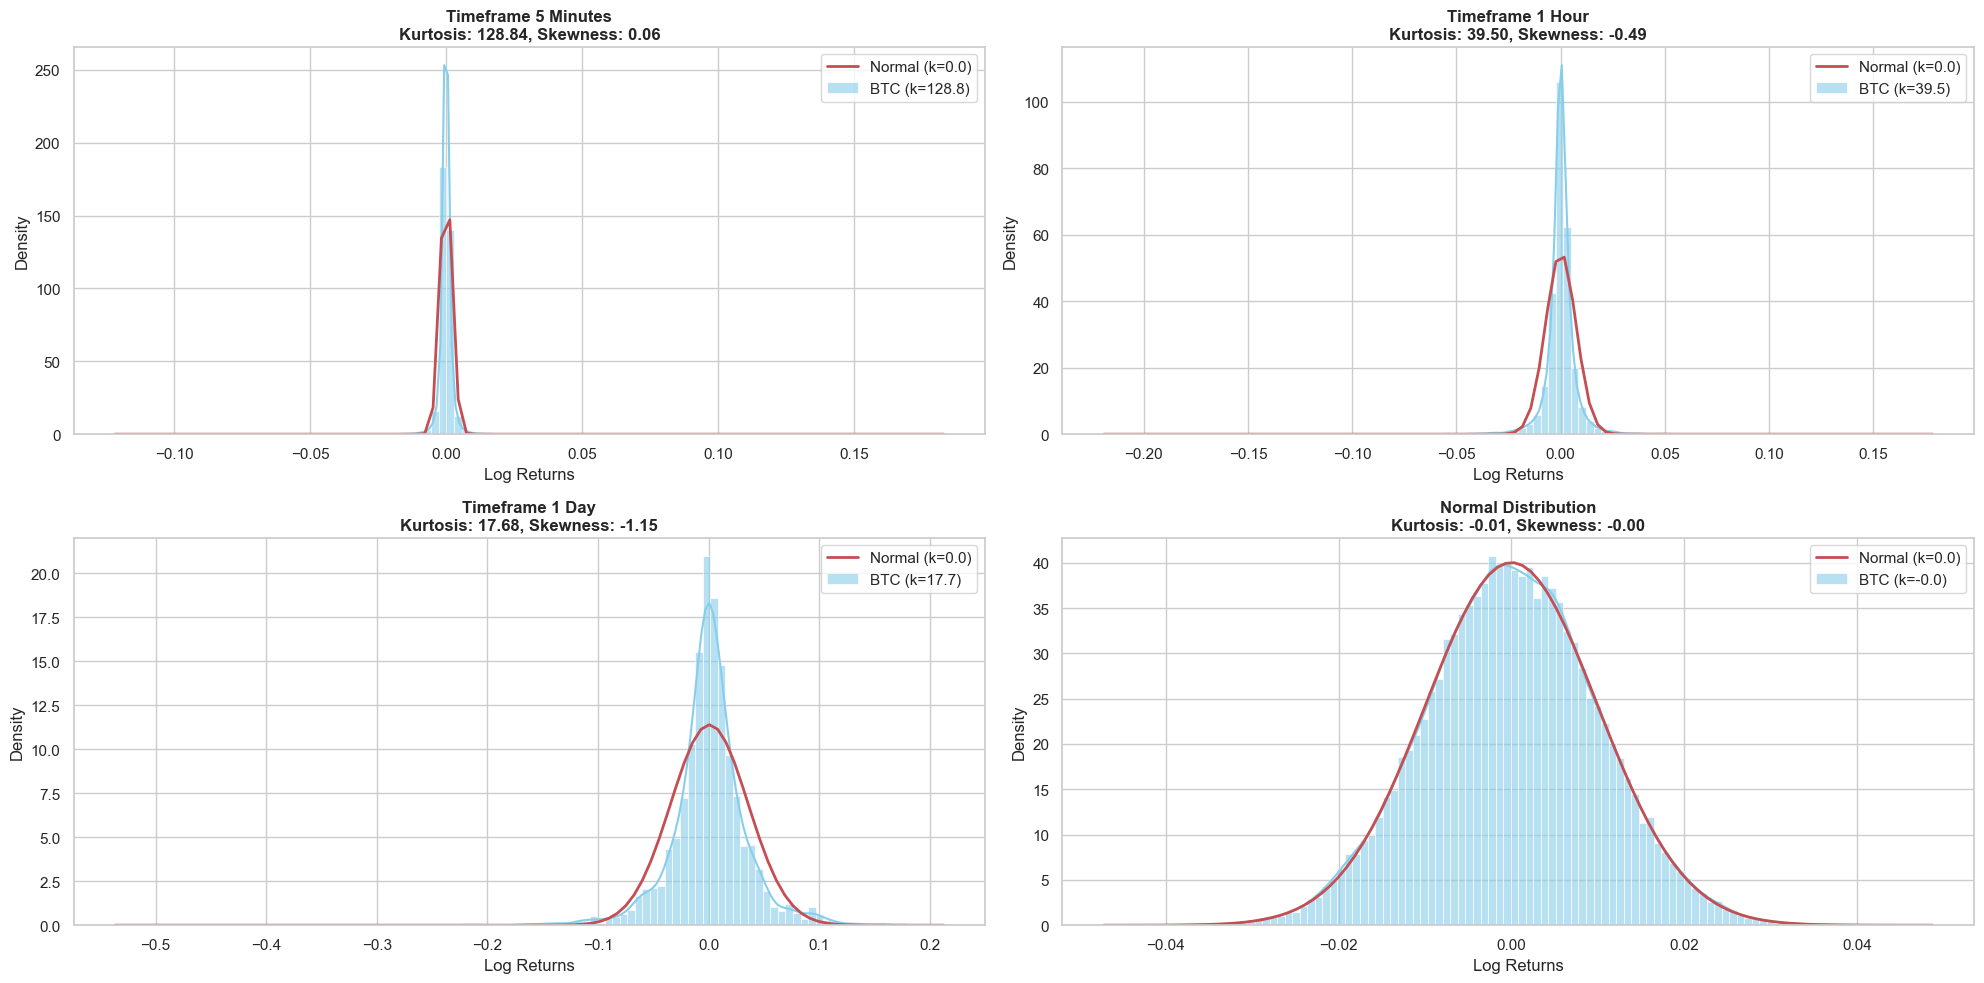

In [65]:
# configuration for multiple plots
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Generating normal distribution dataset
datos = np.random.normal(loc=0, scale=0.01, size=60000)
initial_price = 10000
df_normal = initial_price * np.exp(np.cumsum(datos))
df_normal = pd.DataFrame(df_normal, columns=['Close'])
df_normal['log_return'] = np.log(df_normal['Close'] / df_normal['Close'].shift(1))
df_normal.dropna(inplace=True)

# List of datasets and their names
datasets = [
    (df_5m, "Timeframe 5 Minutes"),
    (df_1h, "Timeframe 1 Hour"),
    (df_1d, "Timeframe 1 Day"),
    (df_normal, "Normal Distribution")
]

# Loop through datasets and plot
for ax, (df, name) in zip(axes.flatten(), datasets):
    
    # Logaritmic Returns Calculation
    data = df.copy()
    
    # Kurtosis Calculation
    k_val = stats.kurtosis(data['log_return'], fisher=True)
    s_val = stats.skew(data['log_return'])
    
    # Logaritmic returns Histogram
    sns.histplot(data['log_return'], bins=100, kde=True, stat="density", 
                 color='skyblue', alpha=0.6, label=f"BTC (k={k_val:.1f})", ax=ax)
    
    # Normal distribution line
    mu, std = stats.norm.fit(data['log_return'])
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)

    # Plot normal distribution
    ax.plot(x, p, 'r', linewidth=2, label="Normal (k=0.0)")
    ax.set_title(f'{name}\nKurtosis: {k_val:.2f}, Skewness: {s_val:.2f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Log Returns')
    ax.set_ylabel('Density')
    ax.legend()
plt.tight_layout()
plt.show()

The comparative analysis of the probability distributions highlights a significant deviation from the Gaussian assumption across all Bitcoin timeframes. While the generated Normal Distribution exhibits a perfect fit with the theoretical curve and a kurtosis near zero, the Bitcoin returns are consistently leptokurtic (Kurtosis > 0), characterized by higher peaks and heavier tails. A clear time-scale dependency is observed: the lower the timeframee, the higher the kurtosis, indicating a greater frequency of extreme outliers and 'black swan' events. As the timeframe increases to 1-day, the distribution arguably converges slightly towards normality, yet it remains non-Gaussian. This confirms that standard deviation is an insufficient risk metric for high-frequency data, necessitating robust models that account for fat tails.

---

<a id="4"></a>
## 4. Outlier Detection & Analysis

In this section, we identify extreme market events using boxplots.

We compare the empirical outliers of Bitcoin against a generated Normal Distribution to quantify the "Fat Tail" risk.

### 4.1. Boxplot Visualization
The boxplots below visually summarize the distribution dispersion.
* **The Box:** Represents the middle 50% of the data.
* **The Whiskers:** Represent the expected range of volatility.
* **The Points:** Represent the **outliers** (extreme events).

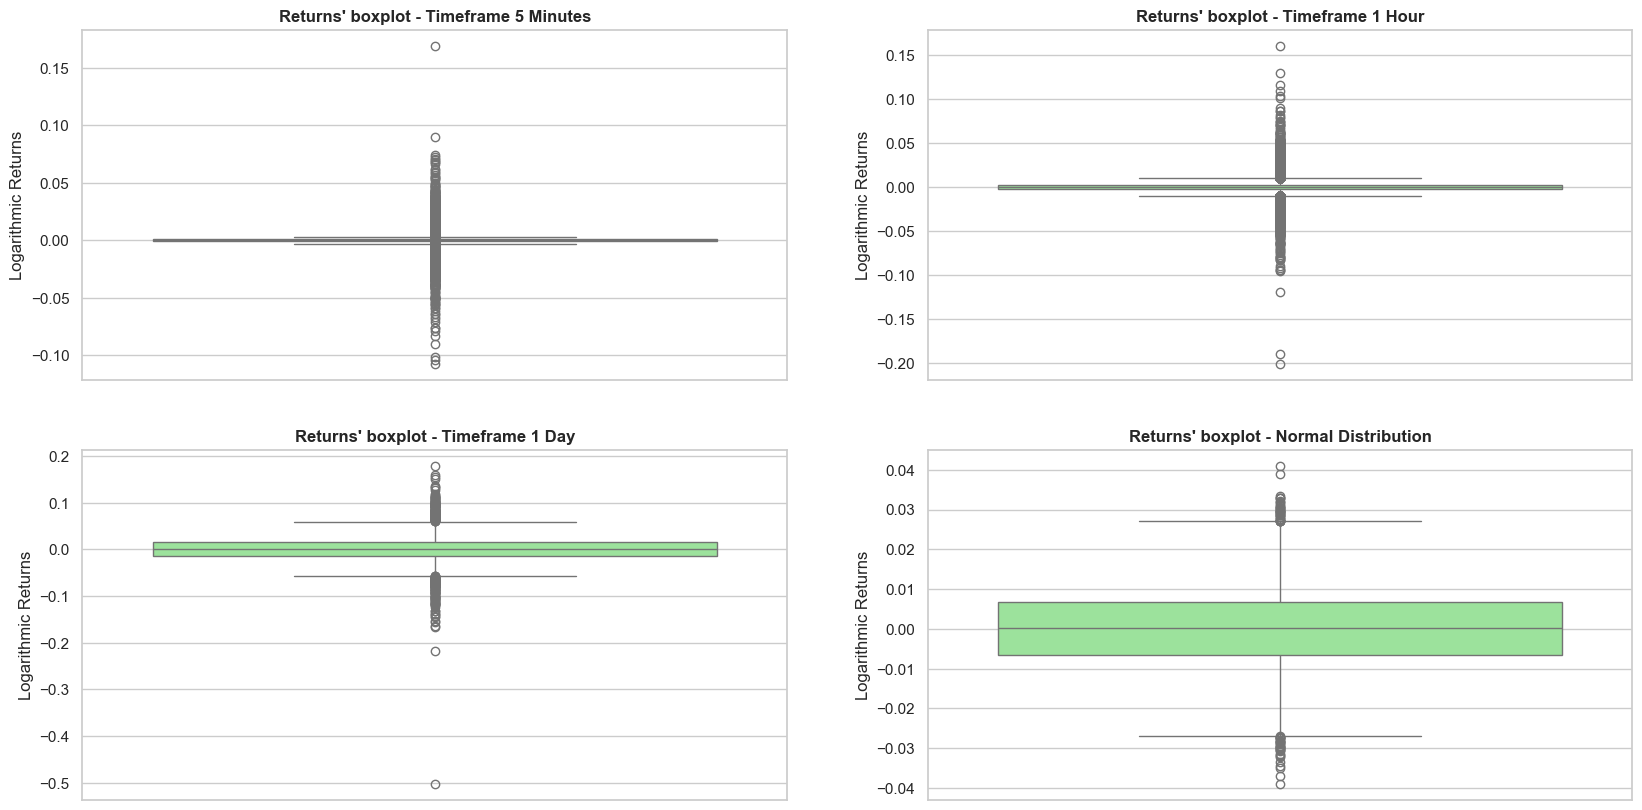

In [66]:
# Preparing data for BoxPlots
datos = np.random.normal(loc=0, scale=0.01, size=10000)
initial_price = 10000
df_normal = initial_price * np.exp(np.cumsum(datos))
df_normal = pd.DataFrame(df_normal, columns=['Close'])
datasets = [
    (df_5m, "Timeframe 5 Minutes"),
    (df_1h, "Timeframe 1 Hour"),
    (df_1d, "Timeframe 1 Day"),
    (df_normal, "Normal Distribution")
]
# Plotting BoxPlots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for ax, (df, name) in zip(axes.flatten(), datasets):
    data = df.copy()
    data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)
    
    sns.boxplot(y=data['log_return'], ax=ax, color='lightgreen')
    ax.set_title(f"Returns' boxplot - {name}", fontsize=12, fontweight='bold')
    ax.set_ylabel('Logarithmic Returns')

### 4.2. Quantitative Diagnosis: Frequency & Magnitude

While the boxplots visually confirm the existence of "fat tails". Therefore, for precise Risk Management, we need to quantify:
1.  **Frequency:** What is the exact probability of an outlier occurring?
2.  **Severity:** What is the maximum and minumun value of an outlier observed?

The following script calculates these metrics.

In [73]:
# Counting outliers function
def count_outliers(df, name):
    # Logaritmic returns
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    data = df['log_return'].dropna()
    # Selecting the outliers
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    body = q3 - q1
    lower_bound = q1 - 1.5 * body
    upper_bound = q3 + 1.5 * body
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    # Counting outliers
    num_outliers = len(outliers)
    num_data = len(data)
    percentage = (num_outliers / num_data) * 100
    max_outlier = np.exp(max(outliers)) - 1
    min_outlier = np.exp(min(outliers)) - 1
    
    # Printing the results
    print(f"OUTLIERS RESULTS OF {name}")
    print(f"№ The number of outliers is: {num_outliers}.")
    print(f"📊 The percentage of outliers is: {percentage:.2f}%.")
    print(f"📈 The highest value is: +{max_outlier*100:.2f}%. ")
    print(f"📉 The lowest value is: {min_outlier*100:.2f}%.")
    print('-'*50)

    return outliers

# Counting outliers for each dataset
outliers_5m = count_outliers(df_5m, "BTC/USDT 5 minutes")
outliers_1h = count_outliers(df_1h, "BTC/USDT 1 hour")
outliers_1d = count_outliers(df_1d, "BTC/USDT 1 day")
outliers_normal = count_outliers(df_normal, "Normal Distribution")

OUTLIERS RESULTS OF BTC/USDT 5 minutes
№ The number of outliers is: 70807.
📊 The percentage of outliers is: 8.54%.
📈 The highest value is: +18.43%. 
📉 The lowest value is: -10.23%.
--------------------------------------------------
OUTLIERS RESULTS OF BTC/USDT 1 hour
№ The number of outliers is: 6617.
📊 The percentage of outliers is: 9.60%.
📈 The highest value is: +17.38%. 
📉 The lowest value is: -18.21%.
--------------------------------------------------
OUTLIERS RESULTS OF BTC/USDT 1 day
№ The number of outliers is: 250.
📊 The percentage of outliers is: 8.67%.
📈 The highest value is: +19.54%. 
📉 The lowest value is: -39.50%.
--------------------------------------------------
OUTLIERS RESULTS OF Normal Distribution
№ The number of outliers is: 69.
📊 The percentage of outliers is: 0.69%.
📈 The highest value is: +4.18%. 
📉 The lowest value is: -3.83%.
--------------------------------------------------


### 4.3. Statistical Findings & Risk Implications

The quantitative results reveal a structural divergence between Bitcoin and the Normal Distribution:

1.  **Frequency Divergence:**
    * **Theory (Normal):** Outliers represent only 0.7% of the sample.
    * **Reality (Bitcoin):** Outliers consistently represent 8.5% to 9.6% of the data across all timeframes.

2.  **Asymmetric Magnitude:**
    * In the Daily timeframe, the downside risk (Lowest Value: -40.00%) significantly exceeds the upside potential (Highest Value: +20.00%).
    * This confirms the Negative Skewness and highlights that crashes are sharper and deeper than rallies.

**Conclusion:** These outliers are not data errors to be removed; they represent the true Tail Risk of the asset. Any predictive model must account for this leptokurtic behavior to avoid catastrophic failure.

---

<a id="5"></a>
## 5. Stationarity Analysis

In this section, we examine if the time series is stable over time.

### 5.1. Visual and Statistical Checks
We use two methods to analyze the behavior of the series:
* **Rolling Statistics:** We plot the moving average and standard deviation to visually check for trends or changing volatility.
* **Augmented Dickey-Fuller (ADF) Test:** A formal statistical test to confirm stationarity.

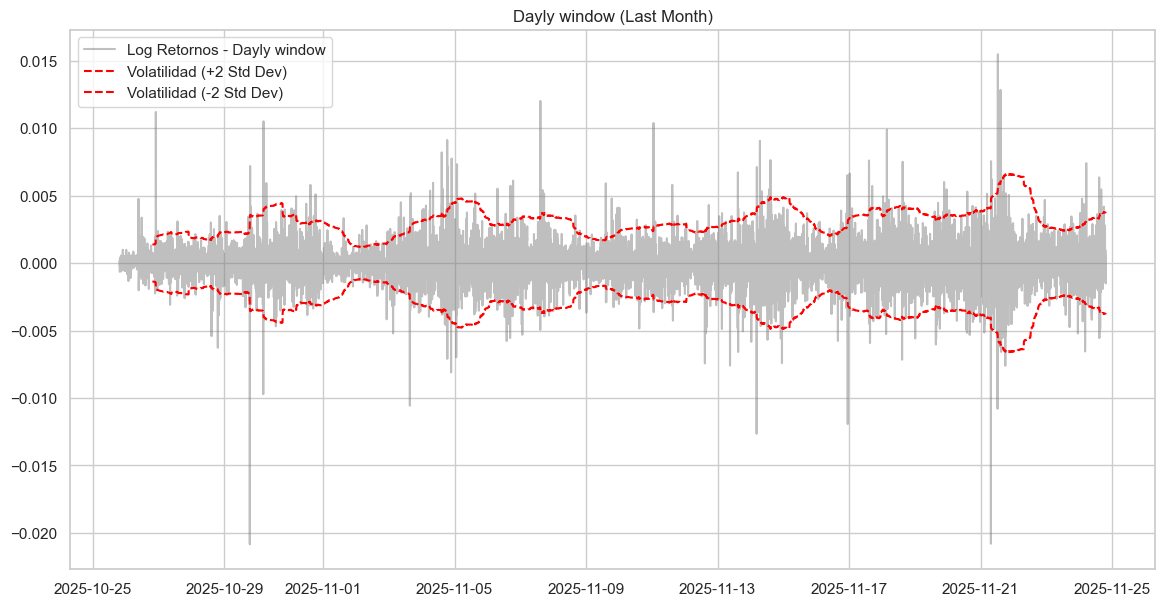

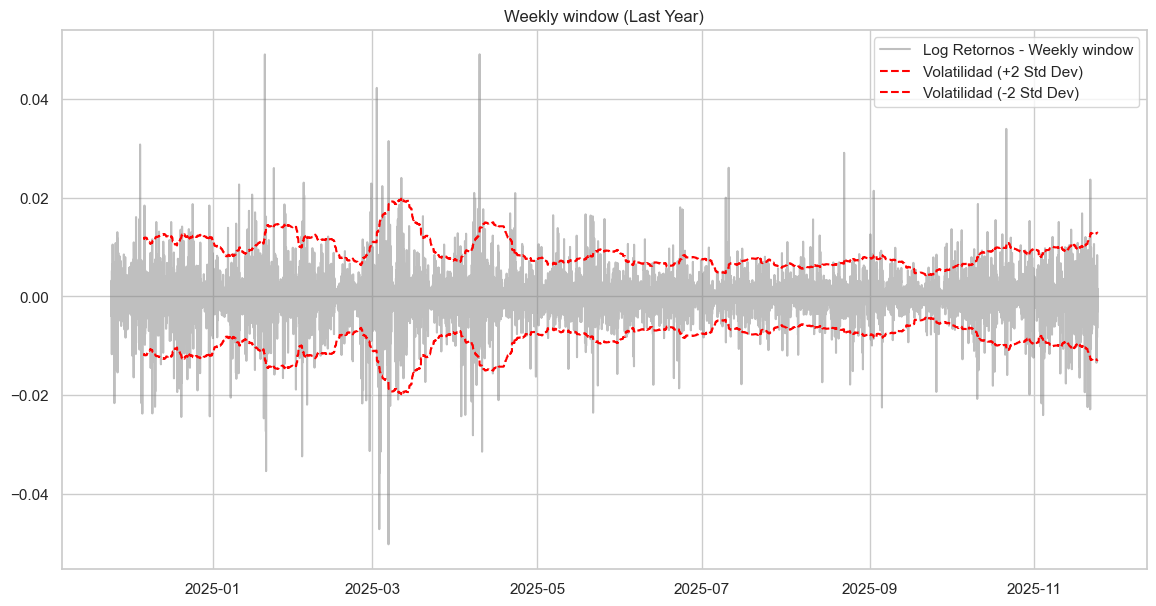

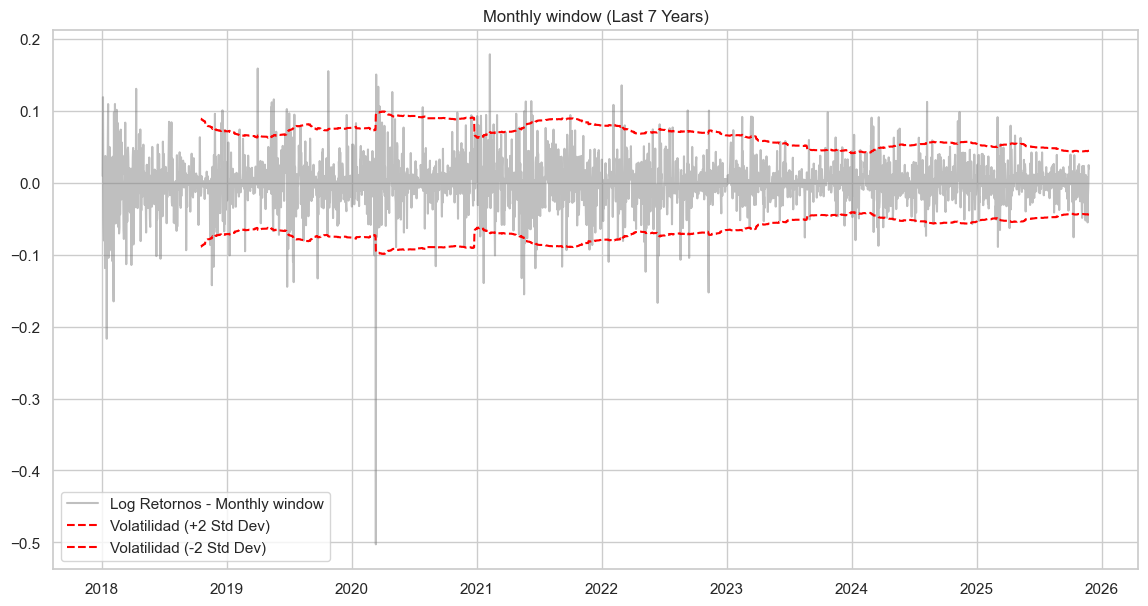

In [79]:
# Heteroskedasticity Visualization
for df, name, period in [(df_5m.tail(24*12*30), "Dayly window", "Month"), (df_1h.tail(24*365), "Weekly window", "Year"), (df_1d, "Monthly window", "7 Years")]:
    window_size = 30 if name == "BTC/USDT 1 day" else 24*7 if name == "BTC/USDT 1 hour" else 24*12
    rolling_mean = df['log_return'].rolling(window=window_size).mean()
    rolling_std = df['log_return'].rolling(window=window_size).std()

    plt.figure(figsize=(14, 7))
    plt.plot(df['log_return'], label=f'Log Retornos - {name}', alpha=0.5, color='grey')
    plt.plot(rolling_std * 2, label='Volatilidad (+2 Std Dev)', color='red', linestyle='--')
    plt.plot(rolling_std * -2, label='Volatilidad (-2 Std Dev)', color='red', linestyle='--')
    plt.title(f'{name} (Last {period})')
    plt.legend()
    plt.show()

### 5.2. Analysis of Rolling Volatility & Heteroskedasticity

The plots above display the Rolling Standard Deviation superimposed on the log-returns. This visualization provides compelling empirical evidence of the time-varying nature of market risk:

**Rejection of Homoskedasticity:**
If Bitcoin returns were homoskedastic (constant variance), the red bands would form parallel, straight lines forming a constant channel. Instead, we observe a distinct "Accordion Effect": the bands expand violently during stress periods and contract during consolidation phases.

**Observation on Monthly Periodicity:** In the 1-Month view, we see a pattern that repeats about four times. This suggests a weekly seasonality, since there are four weeks in a month. However, relying on just one month of data is not enough to be certain. We should treat this as a potential signal that needs to be verified over a longer period to confirm it is a real pattern and not just random noise from this specific month.

**Conclusion:** The assumption of constant variance required by basic linear models (OLS, simple ARIMA) is violated. The volatility structure is dynamic and predictable, necessitating the use of **ARCH/GARCH** class models to forecast the time-varying standard deviation.

### 5.3. Formal Stationarity Test: Augmented Dickey-Fuller (ADF)

While the rolling statistics visually suggest that the mean of the series remains close to zero, visual inspection is subjective. To scientifically validate the suitability of this data for modeling, we must rule out the presence of a **Unit Root**.

We apply the **Augmented Dickey-Fuller (ADF)** test.
* **$H_0$ (Null Hypothesis):** The series has a Unit Root. It is Non-Stationary.
* **$H_a$ (Alternative Hypothesis):** The series does not have a Unit Root. It is Stationary.

We require a p-value $< 0.05$ to reject the null hypothesis and confirm stationarity.

In [ ]:
# ADF Test
def adf_test(dframe, name):
    df = dframe.copy()
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    data = df['log_return'].dropna()
    result = adfuller(data)
    print(f"ADF Test Results for {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f'Critical Value: -3.43')
    if result[1] < 0.05:
        print("The series is stationary (reject H0)")
    else:
        print("The series is non-stationary (fail to reject H0)")
    print('-'*50)
adf_test(df_1d, "BTC/USDT 1 day")
# As this test is computationally expensive, we will use only the last year of data for the lower timeframes
adf_test(df_1h.tail(9000), "BTC/USDT 1 hour (Last year)")
adf_test(df_5m.tail(9000*20), "BTC/USDT 5 minutes (Last year)")

ADF Test Results for BTC/USDT 1 day:
ADF Statistic: -37.574085984179455
p-value: 0.0
Critical Value: -3.43
The series is stationary (reject H0)
--------------------------------------------------
ADF Test Results for BTC/USDT 1 hour (Last year):
ADF Statistic: -23.031013187334107
p-value: 0.0
Critical Value: -3.43
The series is stationary (reject H0)
--------------------------------------------------
ADF Test Results for BTC/USDT 5 minutes (Last year):
ADF Statistic: -52.76838654339927
p-value: 0.0
Critical Value: -3.43
The series is stationary (reject H0)
--------------------------------------------------


### 5.4. ADF Test Results Analysis

The quantitative results provide overwhelming evidence of stationarity across all timeframes:

1.  **Statistical Significance:**
    * In all cases (Daily, Hourly, 5-Min), the p-value is 0.0, which is far below the significance level of 0.05.
    * The **ADF Statistics** ($-37.57$, $-23.03$, $-52.76$) are significantly more negative than the critical value of $-3.43$. This indicates an extremely strong mean-reverting force.

2.  **Implications for Modeling:**
    * **Stationarity Confirmed:** We strongly reject the Null Hypothesis ($H_0$). The log-returns of Bitcoin are stationary in the mean.

**Crucial Note:** The ADF test confirms stationarity in the mean. However, as seen in the Rolling Statistics plot (Section 5.1), the variance is unstable. Therefore, the series is **stationary in mean but heteroskedastic in variance**.

---

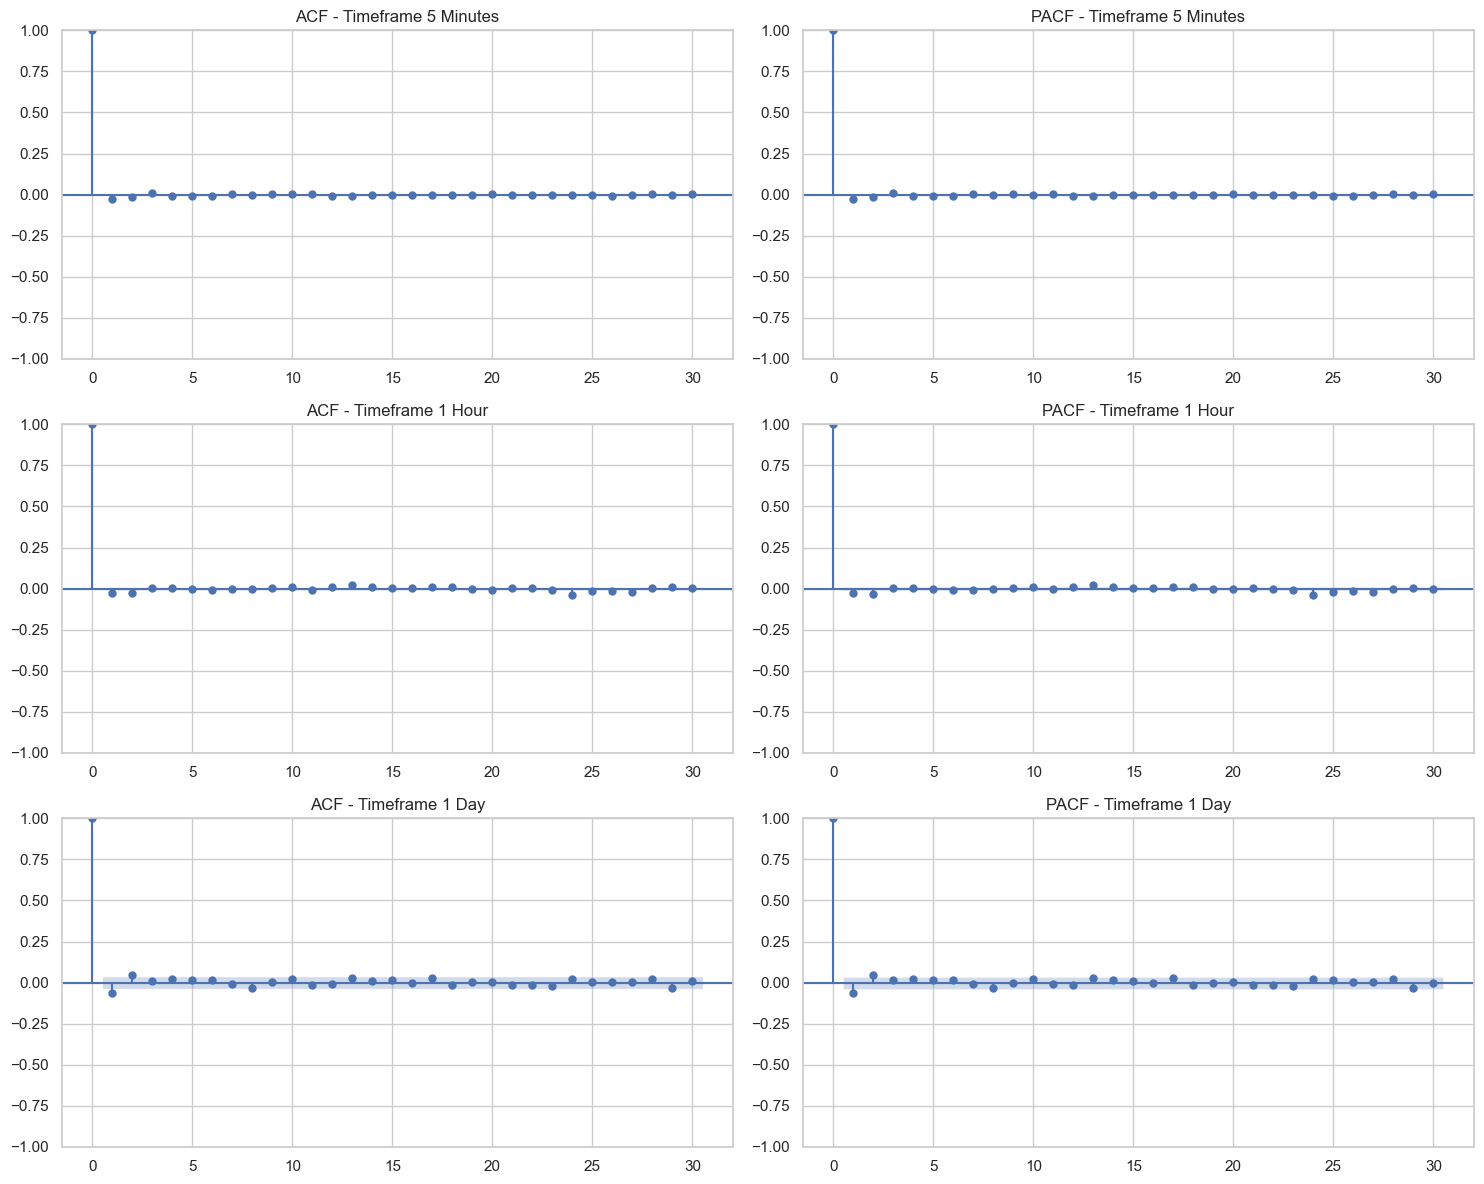

In [68]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Logarithmic returns for each timeframe
df_1d['log_return'] = np.log(df_1d['Close'] / df_1d['Close'].shift(1))
df_1d.dropna(inplace=True)
df_1h['log_return'] = np.log(df_1h['Close'] / df_1h['Close'].shift(1))
df_1h.dropna(inplace=True)  
df_5m['log_return'] = np.log(df_5m['Close'] / df_5m['Close'].shift(1))
df_5m.dropna(inplace=True)

# Preparing the datasets
datasets = [
    (df_5m, "Timeframe 5 Minutes"),
    (df_1h, "Timeframe 1 Hour"),
    (df_1d, "Timeframe 1 Day")
]

# Prepararing the plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plotting ACF and PACF graphs
for ax, (df, name) in zip(axes, datasets):
    plot_acf(df['log_return'], ax=ax[0], lags=30, title=f'ACF - {name}')
    plot_pacf(df['log_return'], ax=ax[1], lags=30, title=f'PACF - {name}')
plt.tight_layout()
plt.show()

Every graph clearly show how the 2 last candles are the ones that have the higher impact in the current candle.
Now we will repeat the process but with squared returns.

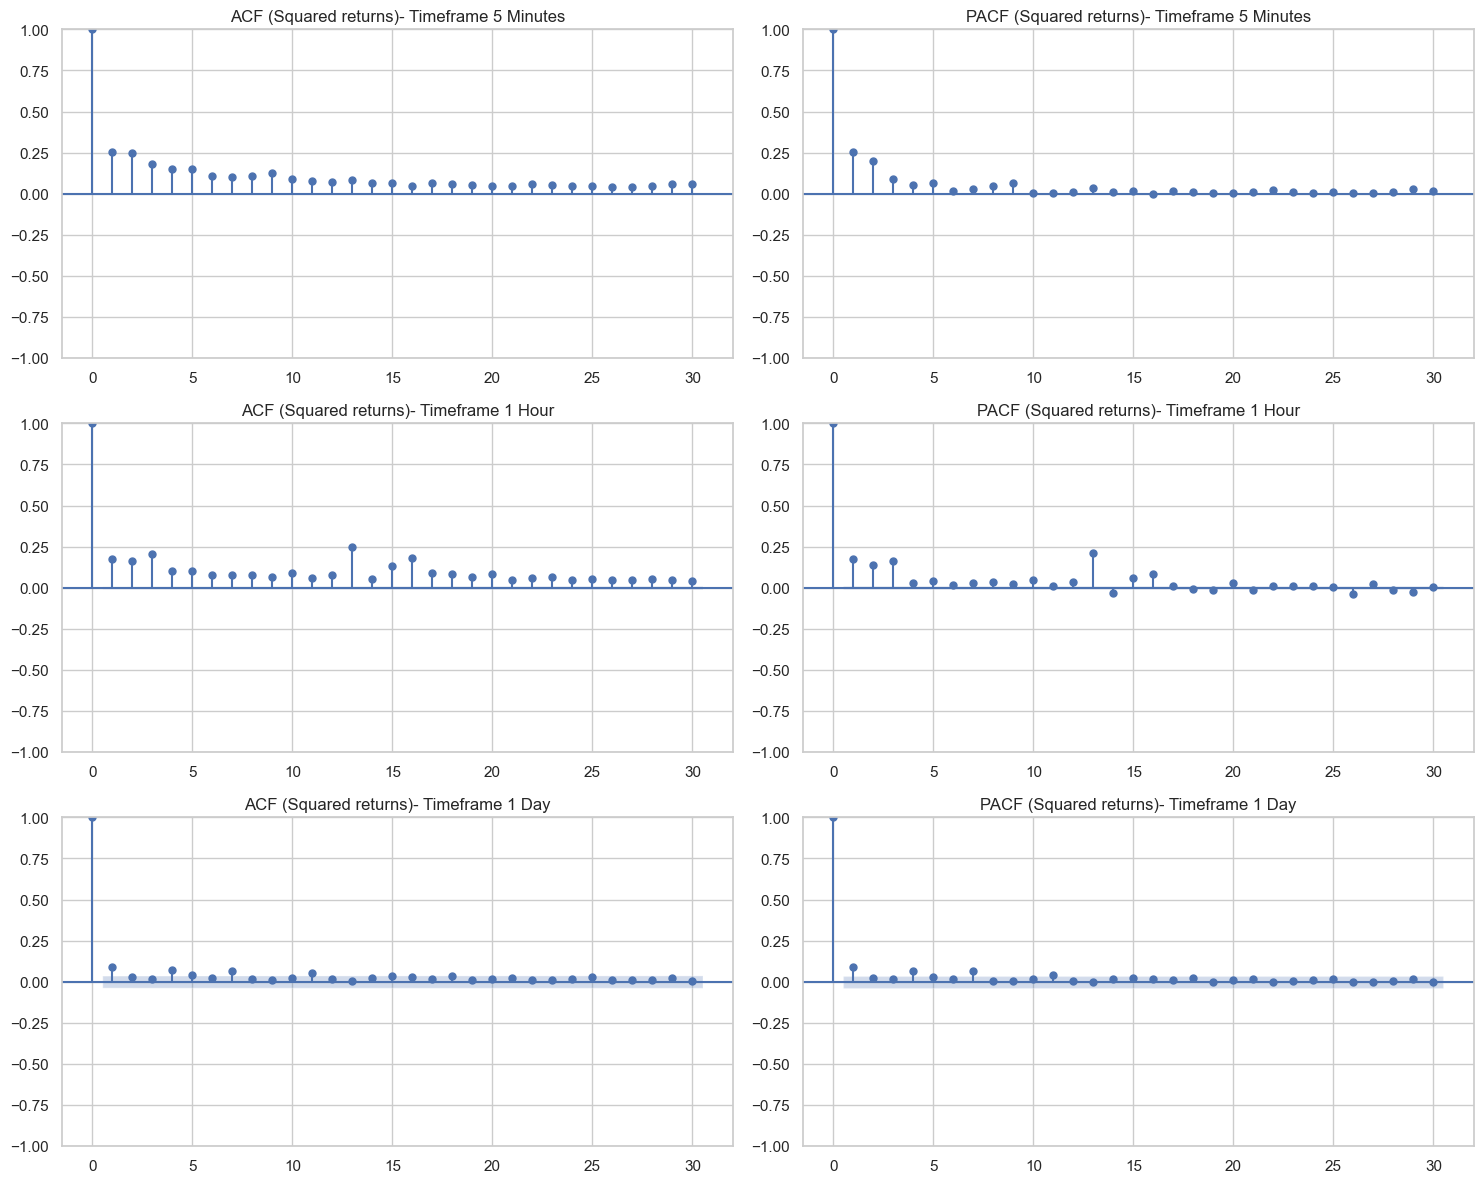

In [69]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Squared logarithmic returns for each timeframe
df_1d['log_return_squared'] = df_1d['log_return'] ** 2
df_1d.dropna(inplace=True)
df_1h['log_return_squared'] = df_1h['log_return'] ** 2
df_1h.dropna(inplace=True)  
df_5m['log_return_squared'] = df_5m['log_return'] ** 2
df_5m.dropna(inplace=True)

# Preparing the datasets
datasets = [
    (df_5m, "Timeframe 5 Minutes"),
    (df_1h, "Timeframe 1 Hour"),
    (df_1d, "Timeframe 1 Day")
]

# Prepararing the plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plotting ACF and PACF graphs
for ax, (df, name) in zip(axes, datasets):
    plot_acf(df['log_return_squared'], ax=ax[0], lags=30, title=f'ACF (Squared returns)- {name}')
    plot_pacf(df['log_return_squared'], ax=ax[1], lags=30, title=f'PACF (Squared returns)- {name}')
plt.tight_layout()
plt.show()

As we can observe, after strong movements, it is probable to see another one. This metric is particularly useful for the risk management.


In order to see analize the stationarity, we are calculating the ADF test (Augmented Dickey-Fuller test).

**ADF test** This test will determine if the series is stationary or not. If the ADF statistic is less than -3.43, then the series is stationary, an the more negative the number is, the more stationary it will be. The p-value tell us the probability that the result is due to chance, assuming the null hypothesis is true.

## Heteroskedasticitiy
Accounting for heteroskedasticity is crucial for accurate risk management. We are seeing if the volatility changes over the time.

As it is shown in the graph, volatility does not remain constant over the time. Therefore, we assume **heteroskedasticity**.

Now, let's take a deeper insight in seasonality. We are using statsmodel library in order to visualize different timeperiod seasonalities.o

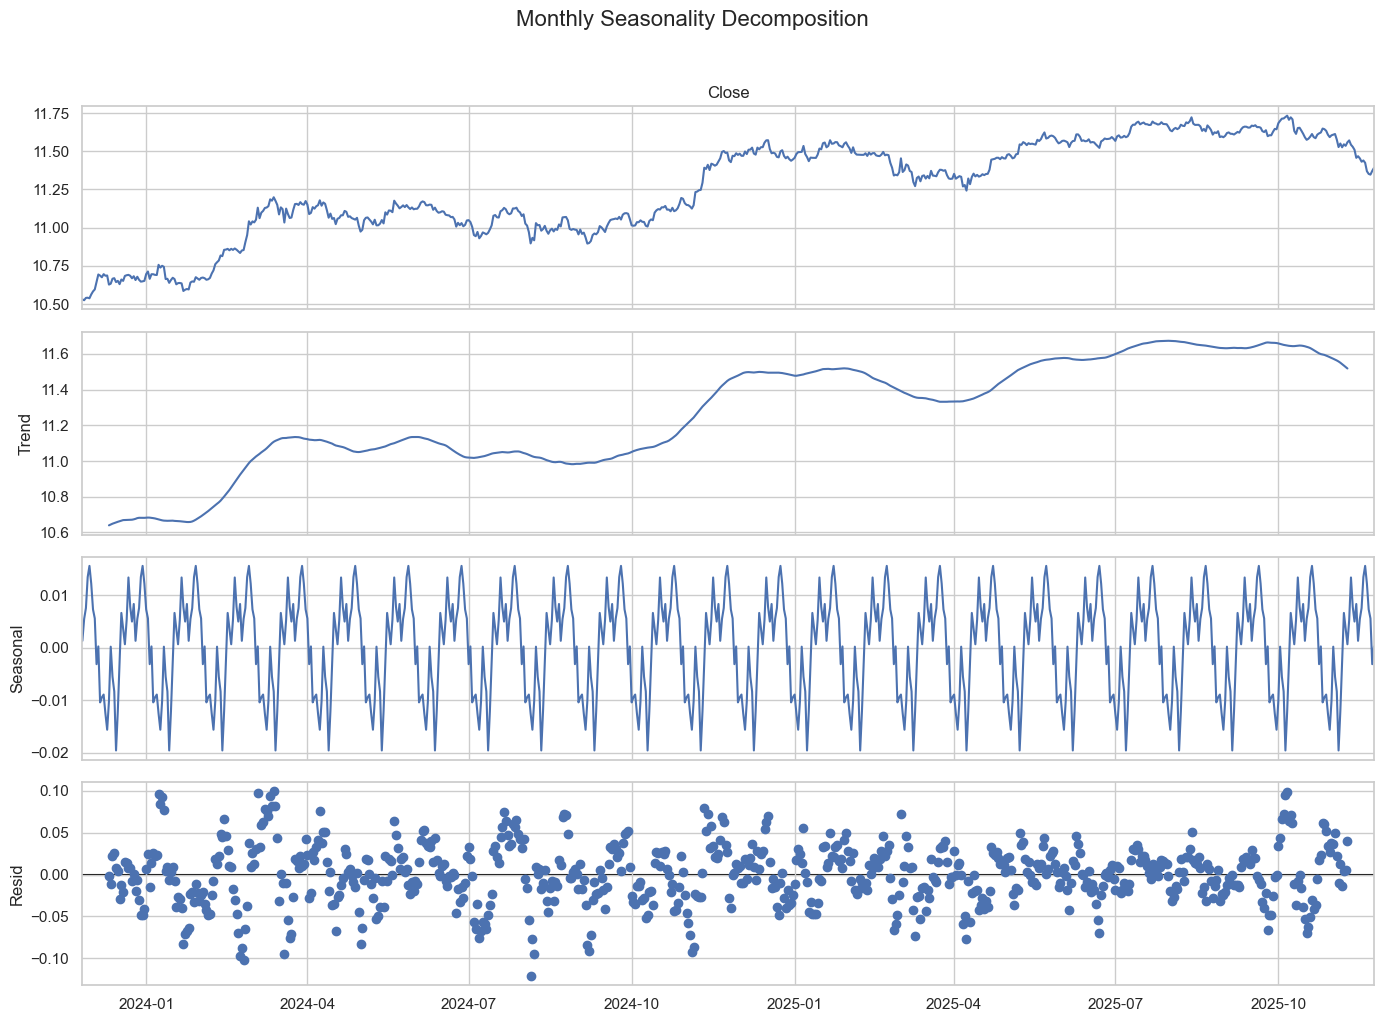

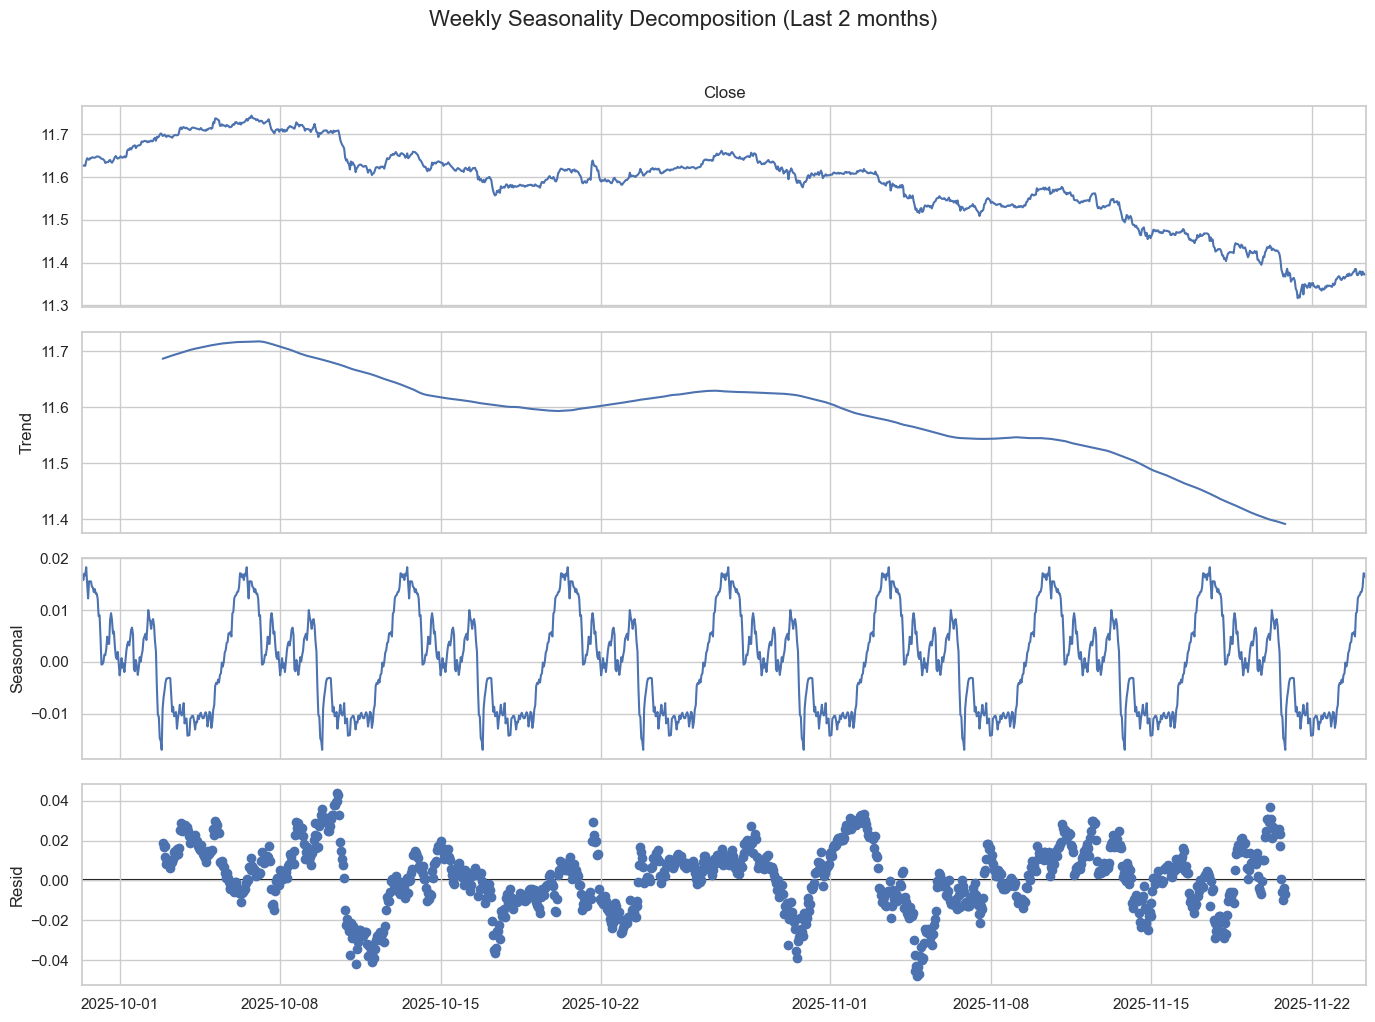

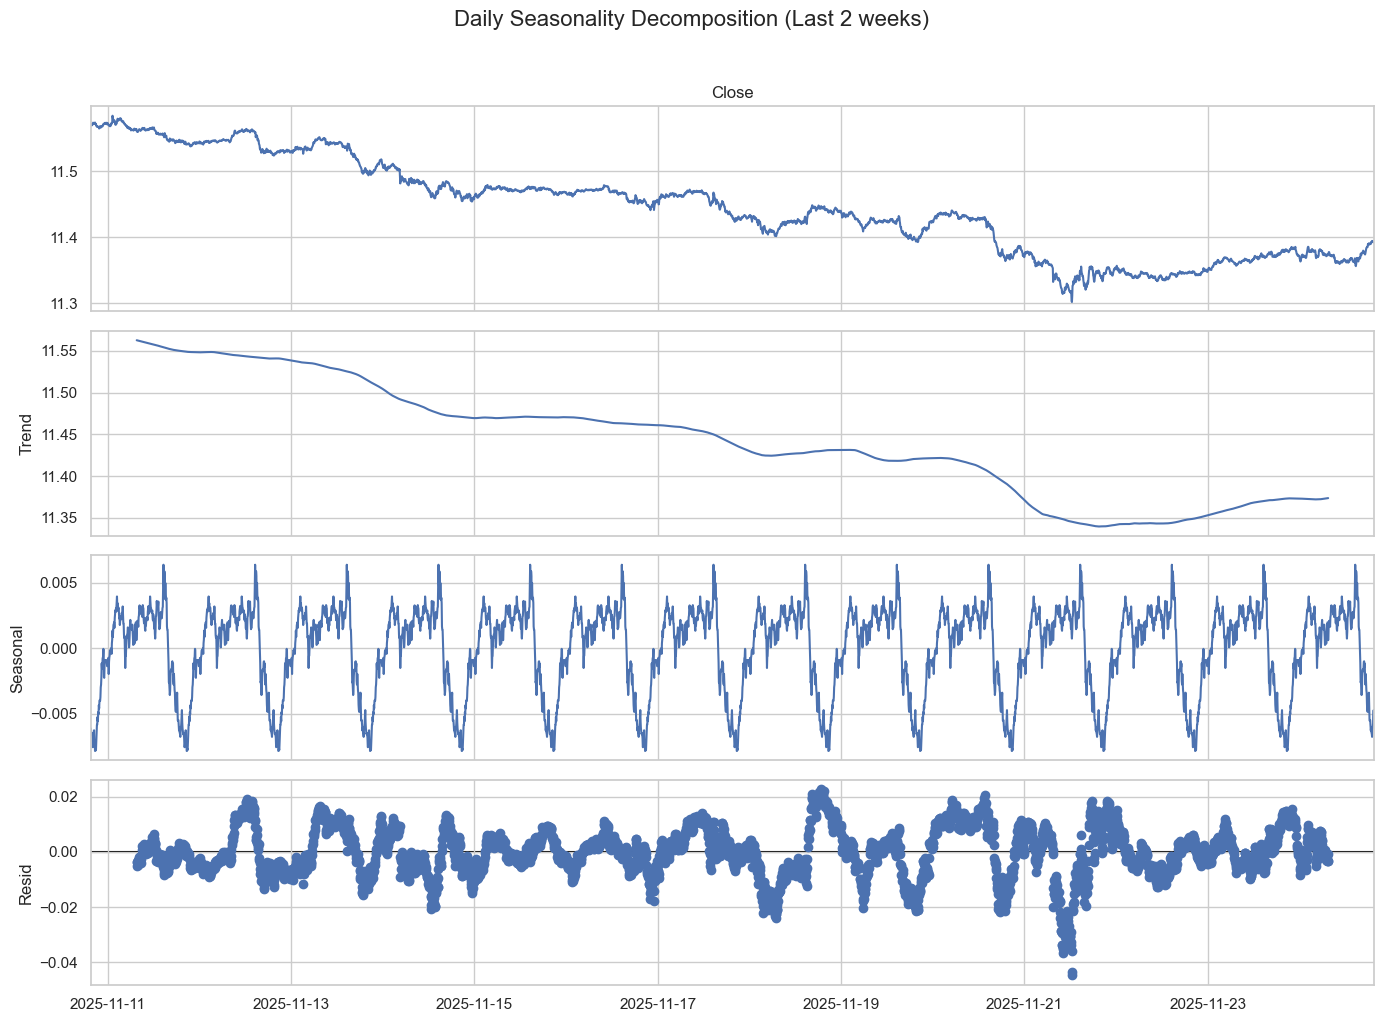

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Monthly seasonality decomposition
log_price = np.log(df_1d['Close'].tail(365*2))
decomposition = seasonal_decompose(log_price, model='additive', period=30)
# Visualization
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Monthly Seasonality Decomposition', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Weekly seasonality decomposition (Last 1 months)
log_price = np.log(df_1h['Close'].tail(8*7*24))  
decomposition = seasonal_decompose(log_price, model='additive', period=24*7)
# Visualization
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Weekly Seasonality Decomposition (Last 2 months)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()  

# Daily seasonality decomposition (Last 100 days)
log_price = np.log(df_5m['Close'].tail(12*24*14))  
decomposition = seasonal_decompose(log_price, model='additive', period=24*12)
# Visualization
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Daily Seasonality Decomposition (Last 2 weeks)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

📊 Final Conclusions on Time Series Decomposition
Based on the multi-timeframe analysis (Monthly, Weekly, and Daily decompositions), we can derive the following insights regarding the Bitcoin (BTC/USDT) price dynamics:

1. Monthly Seasonality

Long-Term Dynamics: The Monthly Decomposition reveals that the Trend component is the dominant force driving prices in the long run.

Negligible Monthly Cycle: The seasonal component at the monthly level exhibits a very low amplitude (≈1%), suggesting that there is no strong calendar effect in Bitcoin. Long-term strategies should focus on trend-following rather than calendar arbitrage.

2. Weekly Seasonality

Liquidity Cycles: The Weekly Decomposition shows a clear and repetitive seasonal pattern with regular dips.

Interpretation: This confirms the structural difference between weekdays and weekends. This seasonality is statistically significant and suggests that price action during off-hours requires careful validation.

3. Predictable Intraday Microstructure

Market Sessions: The Daily Decomposition reveals distinct peaks in activity corresponding to global market sessions (Asian, European/London, and US/NY opens).

Implication: Intraday volatility is not random; it follows a predictable time-of-day schedule. Algorithms should adjust their risk parameters based on the time of day.

4. Confirmation of Conditional Heteroskedasticity

Volatility Clustering: Across all timeframes, the Residuals do not look like Gaussian White Noise. Instead, they exhibit "clustering"—periods of low variance followed by explosive bursts of high variance.

Mathematical Implication: The assumption of constant variance is violated. Linear models (like simple ARIMA) will fail to capture the risk dynamics. This empirically validates the need for Volatility Models (ARCH/GARCH) to correctly estimate the standard deviation for risk management.